In [4]:
import numpy as np 
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm

# Description

## quantify the differences between eco and non-eco in different brain regions

In [5]:
scdata = sc.read_h5ad('/home/rsun@ZHANGroup.local/sly_data/data/final_anno.h5ad')
scdata

AnnData object with n_obs × n_vars = 338818 × 3000
    obs: 'species', 'tissues', 'samples', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster', 'celltype', 'coarse_celltype'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'cluster_colors', 'coarse_celltype_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'samples_colors', 'species_colors', 'tissues_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'harmony_0', 'umap_0'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [16]:


metric_key = 'euclidean'
tissue_res = {}
for tissue in scdata.obs.tissues.unique():

    res_dic = {}

    adata = scdata[scdata.obs['tissues'] == tissue,:] # tissue spcific data
    for species in ['CY','JT','T','QF','M']:
        species_idx = adata.obs['species'] == species 
        subdata = adata[species_idx,:] 

        # idx = np.arange(subdata.shape[0])
        # sel_idx = np.random.choice(idx, size = 3000)
        # meta_cell = subdata[sel_idx].obsm['X_pca_harmony'].mean(axis = 0)
        meta_cell = subdata.obsm['X_pca_harmony'].mean(axis = 0)
        res_dic[species] = meta_cell 
        
    
    res_df = pd.DataFrame(res_dic).T
    sim_df = squareform(pdist(res_df, metric=metric_key))

    if tissue == 'HM':
        hm_sim = sim_df
    score = 2*(sim_df[:3,3:].mean()) - (sim_df[:3,:3].sum()/6 + sim_df[3:,3:].sum()/2)
    tissue_res[tissue] = score 

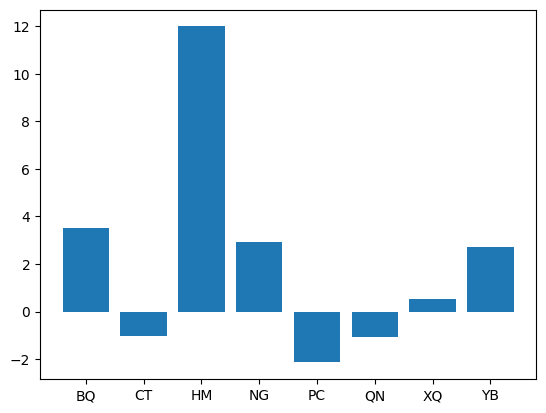

In [17]:
#plt.bar(x = df.columns, height = df.mean(axis = 0))
plt.bar(x = tissue_res.keys(), height= tissue_res.values())
plt.show()

## get the normalized difference scores

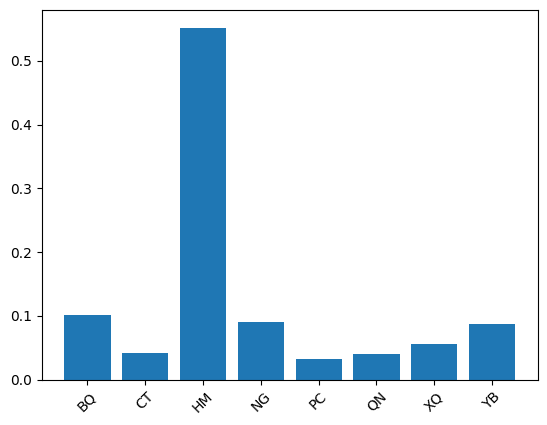

In [42]:
diff = np.array(list(tissue_res.values()))
tmp = np.exp(diff/5)
tmp = tmp/tmp.sum()
plt.bar(x =tissue_res.keys(), height = tmp)
plt.xticks(rotation = 45)
plt.show()

## perform statistical test to check whether HM different is significantly larger than other regions

In [44]:
from scipy import stats
import numpy as np

data = np.concatenate([tmp[:2], tmp[3:]]) 
mu0 = tmp[2]

delta = data - mu0

stat, p_two_tailed = stats.wilcoxon(delta, alternative='two-sided')

mean_diff = np.max(delta)
if mean_diff < 0:
    p_one_tailed = p_two_tailed / 2
else:
    p_one_tailed = 1 - p_two_tailed / 2

print(f"Sample median: {mean_diff :.4f}")
print(f"Wilcoxon stat: {stat:.4f}")
print(f"One-tailed p-value (H1: median < {mu0}): {p_one_tailed:.4f}")

alpha = 0.05
if p_one_tailed < alpha and mean_diff < 0:
    print(f"✅ 拒绝 H0：中位数显著低于 {mu0}")
else:
    print(f"❌ 无法拒绝 H0：中位数不显著低于 {mu0}")

Sample median: -0.4511
Wilcoxon stat: 0.0000
One-tailed p-value (H1: median < 0.5522667443367019): 0.0078
✅ 拒绝 H0：中位数显著低于 0.5522667443367019
